**Importing required libraries**

In [1]:
#importing required libraries
import keras
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2
import numpy as np
import keras.backend as K


2024-04-25 19:00:12.804678: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 19:00:12.831399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 19:00:12.831420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 19:00:12.832076: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-25 19:00:12.836706: I tensorflow/core/platform/cpu_feature_guar

**Creating YOLO model**

we use pretrained resnet50 as backbone instead of darknet due to resource limitations

In [2]:
class ReshapeLayer(tf.keras.layers.Layer):
  def __init__(self, target_shape):
    super(ReshapeLayer, self).__init__()
    self.target_shape = tuple(target_shape)
    self.B=2
    self.C=20
  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'target_shape': self.target_shape
    })
    return config

  def call(self, input):
    #custom reshape layer, each part of the output requires a differente activation
    #for class activations we use softmax 
    #and both bboxes and confidence score require sigmoid activation function
    S = [self.target_shape[0], self.target_shape[1]]
    C = self.C
    B = self.B

    idx1 = S[0] * S[1] * C
    idx2 = idx1 + S[0] * S[1] * B
    
    #class probabilities
    class_probs = K.reshape(input[:, :idx1], (K.shape(input)[0],) + tuple([S[0], S[1], C]))
    class_probs = K.softmax(class_probs)

    #confidence
    confs = K.reshape(input[:, idx1:idx2], (K.shape(input)[0],) + tuple([S[0], S[1], B]))
    confs = K.sigmoid(confs)

    # boxes
    boxes = K.reshape(input[:, idx2:], (K.shape(input)[0],) + tuple([S[0], S[1], B * 4]))
    boxes = K.sigmoid(boxes)

    outputs = K.concatenate([class_probs, confs, boxes])
    return outputs
  

def yolo_model(grids=7,B=2,classes=20):
    lrelu = tf.keras.layers.LeakyReLU(alpha=0.1)
    #loading pretrained resnet50
    backbone=keras.models.load_model("resnet50_448_448.h5")
    regularizer = tf.keras.regularizers.l2(0.0003)

    for layer in backbone.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)
    FC1=keras.layers.Dense(2048,activation=lrelu)(backbone.layers[-1].output)
    FC2=keras.layers.Dense(2048,activation=lrelu)(FC1)
    FC3=keras.layers.Dense(1470,activation=lrelu)(FC2)
    output=ReshapeLayer((7,7))(FC3)
    return keras.models.Model(inputs=backbone.input,outputs=output)
YOLO=yolo_model()
YOLO.summary()


2024-04-25 19:00:13.985397: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-25 19:00:14.010056: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-25 19:00:14.010163: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 448, 448, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 454, 454, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 224, 224, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 224, 224, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

**Extracting labels from VOC xml files**

In [3]:
import argparse
import xml.etree.ElementTree as ET
import os

parser = argparse.ArgumentParser(description='Build Annotations.')
parser.add_argument('dir', default='..', help='Annotations.')

sets = [('2007', 'train'), ('2007', 'val'), ('2007', 'test')]

classes_num = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5,
               'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11,
               'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16,
               'sofa': 17, 'train': 18, 'tvmonitor': 19}


def convert_annotation(year, image_id, f):
    in_file = os.path.join('dataset/VOCdevkit/VOC%s/Annotations/%s.xml' % (year, image_id))
    tree = ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        classes = list(classes_num.keys())
        if cls not in classes or int(difficult) == 1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text),
             int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        f.write(' ' + ','.join([str(a) for a in b]) + ',' + str(cls_id))
for year, image_set in sets:
  print(year, image_set)
  with open(os.path.join('dataset/VOCdevkit/VOC%s/ImageSets/Main/%s.txt' % (year, image_set)), 'r') as f:
      image_ids = f.read().strip().split()
  with open(os.path.join("dataset/VOCdevkit", '%s_%s.txt' % (year, image_set)), 'w') as f:
      for image_id in image_ids:
          f.write('%s/VOC%s/JPEGImages/%s.jpg' % ("VOCdevkit", year, image_id))
          convert_annotation(year, image_id, f)
          f.write('\n')

2007 train
2007 val
2007 test


**We need a custom data generator to read image batches from disk and construct labels**

In [4]:
class YOLO_Datagen(keras.utils.Sequence) :
  def __init__(self, images, labels, batch_size) :
    self.images = images
    self.labels = labels
    self.batch_size = batch_size

  def __read(self,path,label):
    image = cv2.imread(path)#reading image from the respective path
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)#opencv uses BGR by default so the conversion is required
    image_h, image_w = image.shape[0:2]
    #the input size must be predefined, we use 448*448 and resize each image respectivley
    #also the bbox coordinates need to be recalculated and we do such by
    #capturing the aspect ratio of resizing in order to convert the original bbox coordinates
    aspect_x= 448/image_w
    aspect_y=448/image_h
    image = cv2.resize(image, (448, 448))
    image = image / 255.
    label_matrix = np.zeros([7, 7, 30],dtype="float32")
    for l in label:
        l = l.split(',')
        l = np.array(l, dtype=np.int32)
        xmin = l[0]*aspect_x
        ymin = l[1]*aspect_y
        xmax = l[2]*aspect_x
        ymax = l[3]*aspect_y
        cls = l[4]
        #calculating and normalizing the w,h and centers
        x = (xmin + xmax) / 2 
        y = (ymin + ymax) / 2 #/ 448
        w = (xmax - xmin) / 448
        h = (ymax - ymin) / 448
        loc = [x/64, y/64]
        loc_i = int(loc[1])
        loc_j = int(loc[0])
        y = loc[1] - loc_i
        x = loc[0] - loc_j
        #placing labels with respect to their grid cell
        if label_matrix[loc_i, loc_j, 24] == 0:
            label_matrix[loc_i, loc_j, cls] = 1
            label_matrix[loc_i, loc_j, 20:24] = [x, y, w, h]
            label_matrix[loc_i, loc_j, 24] = 1  # response
    return image, label_matrix

  def __len__(self) :
    return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int32)

  def __getitem__(self, idx) :
    batch_x = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    train_image = []
    train_label = []
    for i in range(0, len(batch_x)):
      img_path = batch_x[i]
      label = batch_y[i]
      image, label_matrix = self.__read(f"dataset/{img_path}", label)
      train_image.append(image)
      train_label.append(label_matrix)
    return np.array(train_image), np.array(train_label)


In [5]:
train_datasets = []
val_datasets = []

with open(os.path.join("dataset/VOCdevkit", '2007_train.txt'), 'r') as f:
    train_datasets = train_datasets + f.readlines()
with open(os.path.join("dataset/VOCdevkit", '2007_val.txt'), 'r') as f:
    val_datasets = val_datasets + f.readlines()

X_train = []
Y_train = []

X_val = []
Y_val = []

for item in train_datasets:
  item = item.replace("\n", "").split(" ")
  X_train.append(item[0])
  arr = []
  for i in range(1, len(item)):
    arr.append(item[i])
  Y_train.append(arr)

for item in val_datasets:
  item = item.replace("\n", "").split(" ")
  X_val.append(item[0])
  arr = []
  for i in range(1, len(item)):
    arr.append(item[i])
  Y_val.append(arr)

**Validating the transfomations**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 448, 448, 3)
(4, 7, 7, 30)
(4, 448, 448, 3)
(4, 7, 7, 30)


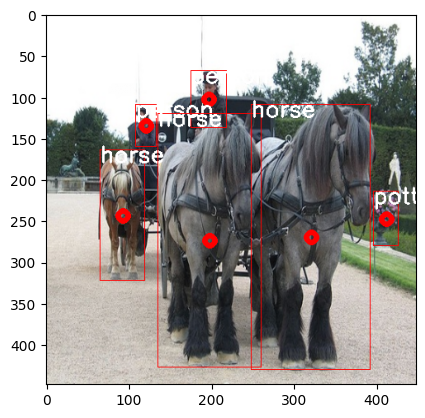

In [6]:
batch_size = 4
train_loader = YOLO_Datagen(X_train, Y_train, batch_size)

val_loader = YOLO_Datagen(X_val, Y_val, batch_size)

x_train, y_train = train_loader.__getitem__(215)
x_val, y_val = val_loader.__getitem__(56)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
inv_map = {v: k for k, v in classes_num.items()}
img=x_train[1]
label=y_train[1]

for y in range(7):
    for x in range(7):
        conf=label[y,x,24]
        if conf==1 :
            xc,yc,w,h=label[y,x,20:24]            
            xc=int((x+xc)*64)
            yc=int((y+yc)*64)
            w=w*448
            h=h*448
            xmin=int(xc-w/2)
            ymin=int(yc-h/2)
            xmax=xmin+int(w)
            ymax=ymin+int(h)
            name=inv_map[np.argmax(label[y,x,0:20])]
            img=cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,0,0),1)
            cv2.putText(img, name, (xmin, ymin+15), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
            img=cv2.circle(img,(xc,yc),6,(255,0,0),5)

plt.imshow(img)


**defining the loss function**

In [7]:
def yolo_head_loss_matrix(grid=(7,7),tensor_size=(448,448)):
    b_c=np.zeros((1,*grid,1,4),dtype="float32")
    b_wh=np.zeros((1,*grid,1,4),dtype="float32")
    for i in range(grid[0]):
        for j in range(grid[1]):
            b_c[0,i,j,0]=[j,i,0,0]
    for i in range(grid[0]):
        for j in range(grid[1]):
            b_wh[0,i,j,0]=[64,64,tensor_size[1],tensor_size[0]]
    return b_c,b_wh
b_c,b_xy=yolo_head_loss_matrix()
def xywh2minmax(xy, wh):
    xy_min = xy - wh / 2
    xy_max = xy + wh / 2

    return xy_min, xy_max
def iou(pred_mins, pred_maxes, true_mins, true_maxes):
    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_wh = pred_maxes - pred_mins
    true_wh = true_maxes - true_mins
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas

    return iou_scores
def yolo_loss(y_true,y_pred):
    label_class = y_true[..., :20]  
    label_box = y_true[..., 20:24]  
    response_mask = y_true[..., 24]  
    response_mask = K.expand_dims(response_mask)

    predict_class = y_pred[..., :20]  
    predict_confidence = y_pred[..., 20:22]  
    predict_box = y_pred[..., 22:]  

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    _label_box=tf.math.add(b_c,_label_box)
    _label_box=tf.math.multiply(_label_box,b_xy)#converts percentages to pixels
    _label_box=tf.expand_dims(_label_box,3)
    label_xy_min, label_xy_max = xywh2minmax(_label_box[...,:2], _label_box[...,2:])

    _predict_box = tf.math.add(b_c,_predict_box)
    _predict_box=tf.math.multiply(_predict_box,b_xy)
    _predict_box=tf.expand_dims(_predict_box,4)
    predict_xy_min, predict_xy_max = xywh2minmax(_predict_box[...,:2], _predict_box[...,2:])

    iou_scores = iou(predict_xy_min, predict_xy_max, label_xy_min, label_xy_max)
    best_ious = K.max(iou_scores, axis=4)  
    best_box = K.max(best_ious, axis=3, keepdims=True)  

    box_mask = K.cast(best_ious >= best_box, K.dtype(best_ious))  

    no_object_loss = 0.5 * (1 - box_mask * response_mask) * K.square(0 - predict_confidence)
    object_loss = box_mask * response_mask * K.square(1 - predict_confidence)
    confidence_loss = no_object_loss + object_loss
    confidence_loss = K.sum(confidence_loss)

    class_loss = response_mask * K.square(label_class - predict_class)
    class_loss = K.sum(class_loss)

    _label_box = K.reshape(label_box, [-1, 7, 7, 1, 4])
    _predict_box = K.reshape(predict_box, [-1, 7, 7, 2, 4])

    _label_box=tf.math.add(b_c,_label_box)
    _label_box=tf.math.multiply(_label_box,b_xy)#converts percentages to pixels
    #_label_box=tf.expand_dims(_label_box,3)
    _predict_box = tf.math.add(b_c,_predict_box)
    _predict_box=tf.math.multiply(_predict_box,b_xy)
    #_predict_box=tf.expand_dims(_predict_box,4)
    predict_xy,predict_wh=_predict_box[...,:2],_predict_box[...,2:]
    
    label_xy,label_wh=_label_box[...,:2],_label_box[...,2:]
    box_mask = K.expand_dims(box_mask)
    response_mask = K.expand_dims(response_mask)

    box_loss = 5 * box_mask * response_mask * K.square((label_xy - predict_xy) / 448)
    box_loss += 5 * box_mask * response_mask * K.square((K.sqrt(label_wh) - K.sqrt(predict_wh)) / 448)
    box_loss = K.sum(box_loss)

    loss = confidence_loss + class_loss + box_loss

    return loss



In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
length=len(train_loader)
losses=[]
val_losses=[]
for epoch in range(50):
    epoch_loss = 0
    # Training phase
    for index,batch in enumerate(train_loader):
        x_batch, y_true_batch = batch  
        with tf.GradientTape() as tape:
            #Forward pass
            y_pred_batch = YOLO(x_batch, training=True)
            
            #Compute loss
            loss = yolo_loss(y_true_batch, y_pred_batch)
        
        has_nan_label = tf.reduce_any(tf.math.is_nan(loss))
        if has_nan_label:
            raise ValueError("NaN values detected in loss")
        #Compute gradients
        gradients = tape.gradient(loss, YOLO.trainable_variables)
        has_nan_gradient = False
        for grad in gradients:
            if tf.reduce_any(tf.math.is_nan(grad)):
                has_nan_gradient = True
                break
        if has_nan_gradient:
            raise ValueError("NaN values detected in gradients")
        #Update weights
        optimizer.apply_gradients(zip(gradients, YOLO.trainable_variables))
        
        #Update metrics
        epoch_loss+=(loss)
    

        print(f"Batch loss: {loss},     Train Loss: {epoch_loss/index},     batch: {index}/{length},         Epoch: {epoch+1}/{50}")
    val_loss=0
    for index,batch in enumerate(val_loader):
        x_batch, y_true_batch = batch  
        y_pred_batch = YOLO(x_batch)
        loss = yolo_loss(y_true_batch, y_pred_batch)
        val_loss+=(loss)
    val_losses.append(val_loss)
    print ("===========================================")
    print(f"validation loss: {val_loss/len(val_loader)}")
    losses.append(epoch_loss)


2024-04-25 19:00:24.264143: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-25 19:00:24.302778: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-25 19:00:24.490959: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-25 19:00:28.368680: I external/local_xla/xla/service/service.cc:168] XLA service 0x2b27b700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-25 19:00:28.368704: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-04-25 19:00:28.372270: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714059028.439826   35854 device_compiler.h:18

Batch loss: 111.58812713623047,     Train Loss: inf,     batch: 0/626,         Epoch: 1/50
Batch loss: 109.99566650390625,     Train Loss: 221.58380126953125,     batch: 1/626,         Epoch: 1/50
Batch loss: 93.33989715576172,     Train Loss: 157.46185302734375,     batch: 2/626,         Epoch: 1/50
Batch loss: 88.28617095947266,     Train Loss: 134.40328979492188,     batch: 3/626,         Epoch: 1/50
Batch loss: 102.39615631103516,     Train Loss: 126.40150451660156,     batch: 4/626,         Epoch: 1/50
Batch loss: 91.46587371826172,     Train Loss: 119.41438293457031,     batch: 5/626,         Epoch: 1/50
Batch loss: 81.8984146118164,     Train Loss: 113.1617202758789,     batch: 6/626,         Epoch: 1/50
Batch loss: 83.08185577392578,     Train Loss: 108.8646011352539,     batch: 7/626,         Epoch: 1/50
Batch loss: 70.06250762939453,     Train Loss: 104.01433563232422,     batch: 8/626,         Epoch: 1/50
Batch loss: 74.36003875732422,     Train Loss: 100.71941375732422,    

In [9]:
YOLO.save("YOLO_.h5")

/home/amir/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


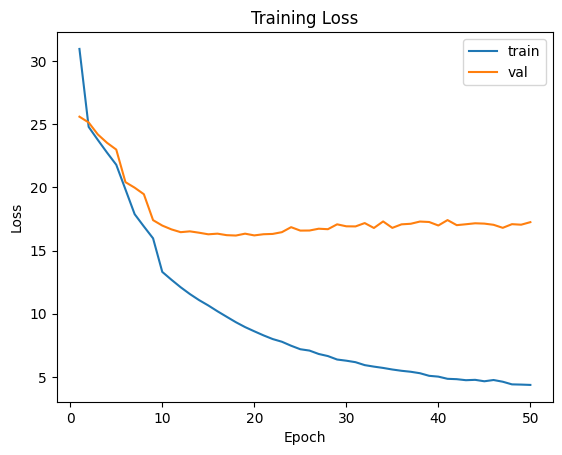

In [10]:
loss_train=np.array(losses)/626
loss_val=np.array(val_losses)/len(val_loader)
plt.plot(range(1,51),loss_train,label="train")
plt.plot(range(1,51),loss_val,label="val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

**Computing validation loss**

In [11]:
losses=[]
val_loss = 0
loss=0
validation_predicts=[]
validation_labels=[]
# Training phase
for index,batch in enumerate(val_loader):
    x_batch, y_true_batch = batch  
    y_pred_batch = YOLO(x_batch)
    loss = yolo_loss(y_true_batch, y_pred_batch)
    val_loss+=(loss)
    validation_predicts.append(y_pred_batch)    
    validation_labels.append(y_true_batch)
    

print(f"validation loss: {val_loss/len(val_loader)}")



validation loss: 17.24756622314453


**Non maximum supersession and map**

In [105]:

def nms(bboxes:list,):
    if len(bboxes)==0:
        return []
    size=bboxes.shape[0]
    boxes=np.zeros((size,5))
    for j in range(size):
        if bboxes[j,20]>bboxes[j,21]:
            boxes[j,1:]=bboxes[j,22:26]
            boxes[j,0]=bboxes[j,20]
        else :
            boxes[j,1:]=bboxes[j,26:]
            boxes[j,0]=bboxes[j,21]
        #print (boxes[j,0])
    xc = boxes[:, 1]
    yc = boxes[:, 2]
    w = boxes[:, 3]
    h = boxes[:, 4]
    x1=xc-(w/2)
    y1=yc-(h/2)
    x2=x1+w
    y2=y1+h
    area=w*h
    scores = boxes[:, 0]
    idxs = np.argsort(scores)
    keep = []
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[:last]]
        # push S in filtered predictions list
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > 0.5)[0])))
    return boxes[keep]
def infernce_post_process(pred,size=7):
    boxes={}
    _pred=tf.reshape(pred[...,22:],(1,7,7,2,4))

    """if pred[...,20]>pred[...,21]:
        chosen_box=[22,23,24,25]
    else :
        chosen_box=[26,27,28,29]"""
    _pred=tf.math.add(b_c,_pred)
    _pred=tf.math.multiply(_pred,b_xy)
    _pred=tf.reshape(_pred,(7,7,8))
    pred=np.array(pred)
    pred[...,22:]=np.array(_pred)
    pred=pred.reshape(size*size,30)
    #print (pred.shape)
    #pred[...,0:20]=np.argmax(pred[...,0:20],axis=1)
    for class_id in range(20):
        indexes=np.where(np.argmax(pred[...,0:20],axis=1)==class_id)[0]
        #print (class_id)
        bboxes=pred[indexes]
        bboxes=nms(bboxes)
        boxes[class_id]=bboxes
    return boxes
    
classes=dict((v, k) for k, v in classes_num.items())


**plot validation images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


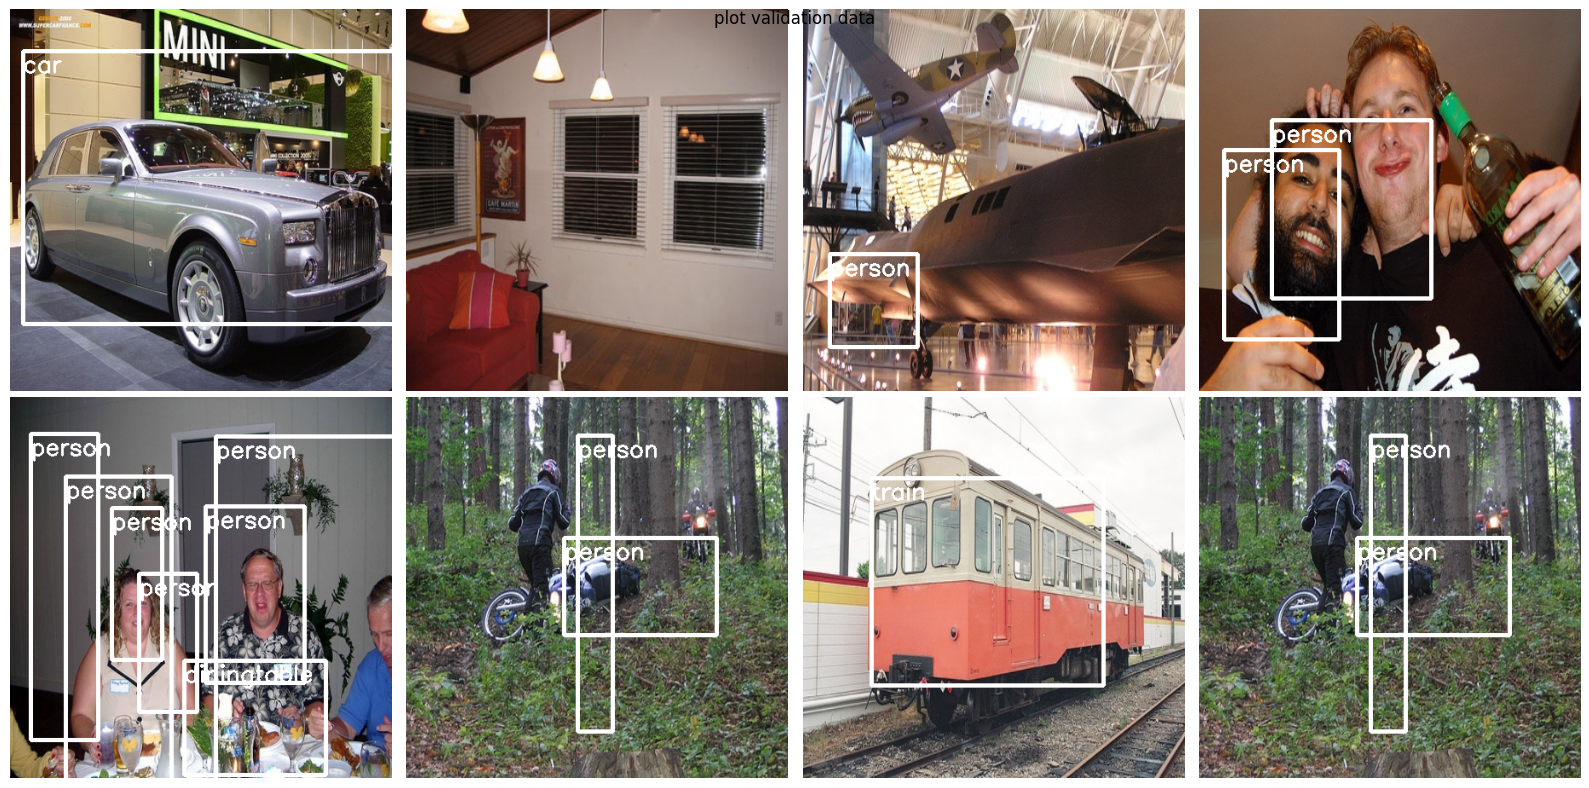

In [219]:
val_images=[]
for j in np.random.randint(150, size=(8)):
    test_image=val_loader.__getitem__(j)[0][0]
    coords=validation_predicts[j][0]
    coords=infernce_post_process(coords)
    for j in coords.keys():

        for i in coords[j]:
            if i[0]>0.3:
                xc,yc,w,h=i[1:].astype("int32")
                xs=xc-w//2
                xf=xs+w
                ys=yc-h//2
                yf=ys+h
                test_image=cv2.rectangle(test_image,(xs,ys),(xf,yf),(255,255,255),3)
                test_image=cv2.putText(test_image, classes[j], (xs,ys+25), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    val_images.append(test_image)

# Plot the images
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in enumerate(axs.flat):
    ax.imshow(val_images[i])
    ax.axis('off')
plt.tight_layout()
plt.suptitle("plot validation data")

plt.show()

**plot train images**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


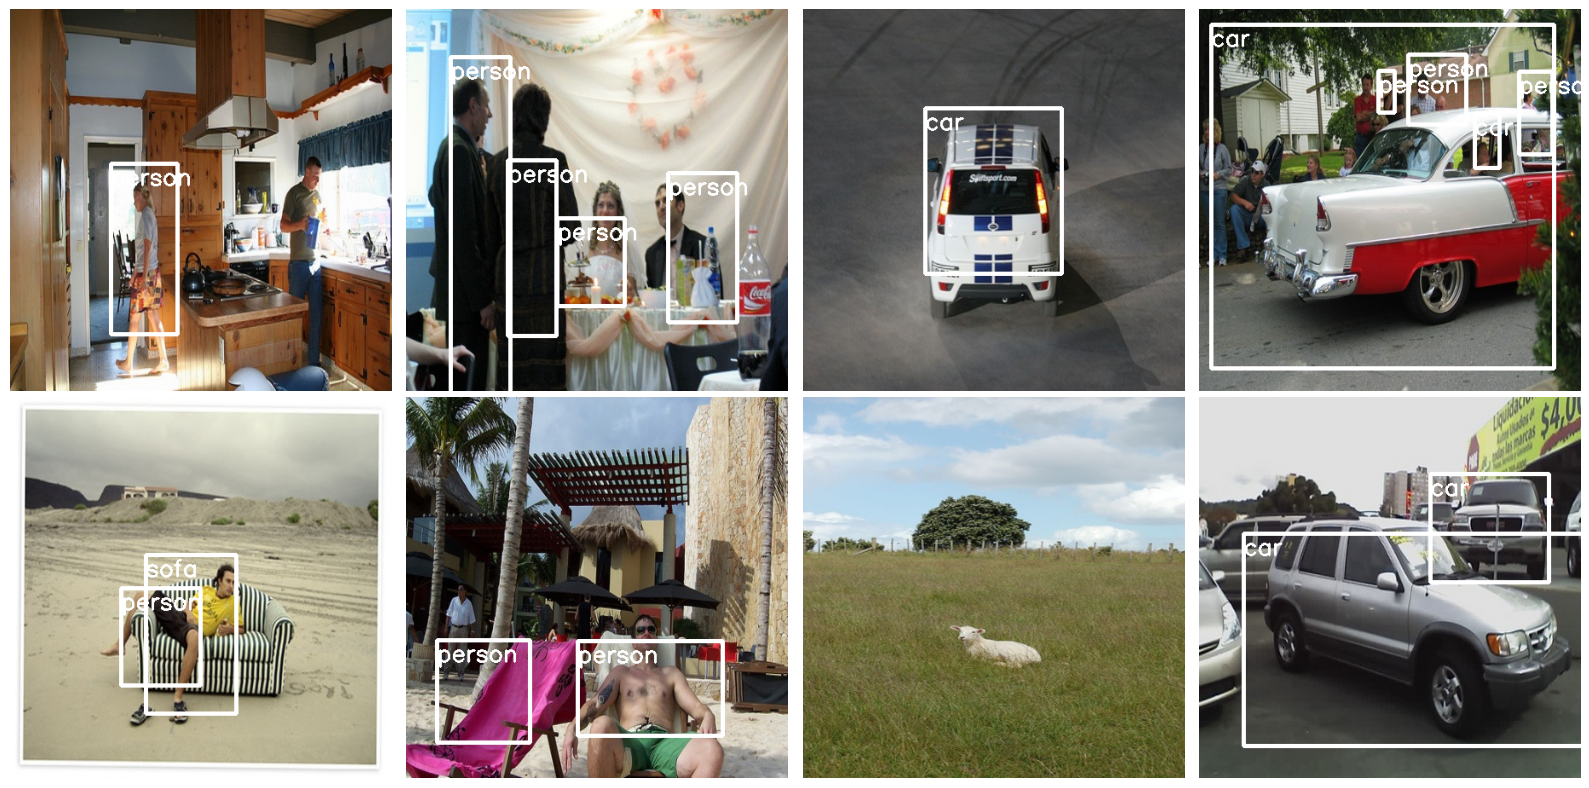

In [200]:
train_image=[]
for j in np.random.randint(600, size=(8)):
    test_batch=train_loader.__getitem__(j)[0]
    pred=YOLO(test_batch)
    test_image=test_batch[0]
    coords=pred[0]
    coords=infernce_post_process(coords)
    for j in coords.keys():

        for i in coords[j]:
            if i[0]>0.4:
                xc,yc,w,h=i[1:].astype("int32")
                xs=xc-w//2
                xf=xs+w
                ys=yc-h//2
                yf=ys+h
                test_image=cv2.rectangle(test_image,(xs,ys),(xf,yf),(255,255,255),3)
                test_image=cv2.putText(test_image, classes[j], (xs,ys+25), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    train_image.append(test_image)
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for i, ax in enumerate(axs.flat):
    ax.imshow(train_image[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


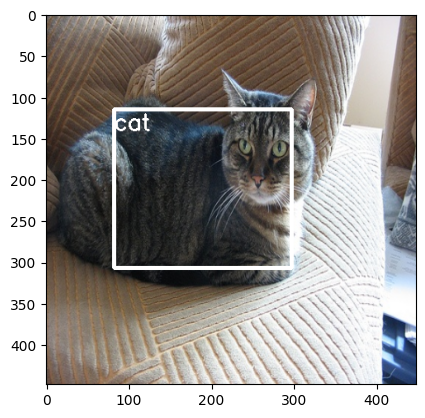

In [182]:
test_batch=train_loader.__getitem__(97)[0]
pred=YOLO(test_batch)
test_image=test_batch[0]
coords=pred[0]
coords=infernce_post_process(coords)
for j in coords.keys():

    for i in coords[j]:
        if i[0]>0.4:
            xc,yc,w,h=i[1:].astype("int32")
            xs=xc-w//2
            xf=xs+w
            ys=yc-h//2
            yf=ys+h
            test_image=cv2.rectangle(test_image,(xs,ys),(xf,yf),(255,255,255),3)
            test_image=cv2.putText(test_image, classes[j], (xs,ys+25), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
plt.imshow(test_image)


**compute classification metrics for each grid**

In [234]:
def gt_post_process(label,size=7):
    boxes={}
    _label=tf.reshape(label[...,20:24],(1,7,7,1,4))

    _label=tf.math.add(b_c,_label)
    _label=tf.math.multiply(_label,b_xy)
    _label=tf.reshape(_label,(7,7,4))
    label=np.array(label)
    label[...,20:24]=np.array(_label)
    label=label.reshape(size*size,30)
    label=label[np.where(label[:,24]==1)[0]]
    #print (pred.shape)
    #pred[...,0:20]=np.argmax(pred[...,0:20],axis=1)
    for class_id in range(20):
        indexes=np.where(np.argmax(label[...,0:20],axis=1)==class_id)[0]
        #print (class_id)
        bboxes=label[indexes,20:24]
        boxes[class_id]=bboxes
    return boxes

In [342]:
pred_list=[]
for j in validation_predicts:

    for i in j:
        i=np.array(i)
        i=i.reshape(49,30)
        
        pred_list.append(i[...,20:22])
label_list=[]
for j in validation_labels:
    
    for i in j:
        i=np.array(i)
        i=i.reshape(49,30)
        label_list.append(i[...,24])

In [343]:
pred_list=np.max(np.array(pred_list),axis=2)

In [344]:
pred_list[pred_list>0.5]=1
pred_list[pred_list<=0.5]=0
pred_list

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [348]:
from sklearn.metrics import classification_report
print (classification_report(np.array(label_list).flatten(),pred_list.flatten()))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97    117180
         1.0       0.42      0.08      0.13      5810

    accuracy                           0.95    122990
   macro avg       0.69      0.54      0.55    122990
weighted avg       0.93      0.95      0.94    122990

